In [ ]:
!pip install -q "transformers>=4.44.0" "datasets>=2.20.0" \
              "accelerate>=0.32.0" "scikit-learn" "pandas"

In [ ]:
import os
import time
import math
from dataclasses import dataclass
from typing import Optional, Dict, Any, List
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    BertConfig,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)

@dataclass
class KDConfig:
    teacher_name: str = "bert-base-uncased"
    max_length: int = 128
    batch_size: int = 32
    lr: float = 2e-5
    num_epochs: int = 10
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    alpha: float = 0.7          # KD loss weight
    temperature: float = 2.0    # KD temperature
    seed: int = 42
    train_fraction: float = 1.0 # 1.0, 0.1, 0.01 etc.
    student_num_layers: int = 4
    student_hidden_size: int = 768

def set_seed(seed: int):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def measure_inference_time(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    max_batches: Optional[int] = 50,
) -> float:
    """
    Returns avg seconds per example over at most max_batches.
    """
    model.eval()
    n_examples = 0
    start = time.time()

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if max_batches is not None and i >= max_batches:
                break
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            _ = model(input_ids=input_ids, attention_mask=attention_mask)
            n_examples += input_ids.size(0)

    total_time = time.time() - start
    if n_examples == 0:
        return math.nan
    return total_time / n_examples


In [ ]:
def load_sst2_dataloaders(
    tokenizer,
    max_length: int,
    batch_size: int,
    train_fraction: float,
    seed: int,
):
    """
    Loads GLUE SST-2, creates tokenized torch DataLoaders.
    Uses validation as eval set (GLUE test labels are hidden).
    """
    raw_datasets = load_dataset("glue", "sst2")

    # Subsample training set for different data regimes
    train_dataset = raw_datasets["train"]
    if train_fraction < 1.0:
        train_dataset = train_dataset.shuffle(seed=seed)
        n_train = int(len(train_dataset) * train_fraction)
        train_dataset = train_dataset.select(range(n_train))

    # Debug: check label distribution for this fraction
    labels = train_dataset["label"]
    pos = sum(1 for x in labels if x == 1)
    neg = sum(1 for x in labels if x == 0)
    print(f"[DEBUG] train_fraction={train_fraction}: "
          f"{len(labels)} examples (neg={neg}, pos={pos})")

    val_dataset = raw_datasets["validation"]

    def tok_fn(batch):
        result = tokenizer(
            batch["sentence"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )
        result["labels"] = batch["label"]
        return result

    train_tokenized = train_dataset.map(tok_fn, batched=True)
    val_tokenized = val_dataset.map(tok_fn, batched=True)

    cols = ["input_ids", "attention_mask", "labels"]
    train_tokenized.set_format(type="torch", columns=cols)
    val_tokenized.set_format(type="torch", columns=cols)

    train_loader = DataLoader(
        train_tokenized, batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        val_tokenized, batch_size=batch_size, shuffle=False
    )

    return train_loader, val_loader


In [ ]:
def build_teacher(config: KDConfig) -> BertForSequenceClassification:
    model = BertForSequenceClassification.from_pretrained(
        config.teacher_name,
        num_labels=2,
    )
    return model

def build_student(config: KDConfig) -> BertForSequenceClassification:
    """
    Build a smaller BERT-style student:
    - fewer layers
    - smaller hidden size
    """
    teacher_config = BertConfig.from_pretrained(config.teacher_name)

    # clone the config safely
    student_config = copy.deepcopy(teacher_config)

    student_config.num_hidden_layers = config.student_num_layers
    student_config.hidden_size = config.student_hidden_size

    # keep BERT's rule that hidden_size / num_attention_heads ≈ 64
    student_config.num_attention_heads = max(
        1, config.student_hidden_size // 64
    )
    student_config.intermediate_size = config.student_hidden_size * 4

    student_model = BertForSequenceClassification(student_config)
    return student_model

def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device,
):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, macro_f1


In [ ]:
def train_teacher(
    config: KDConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    model = build_teacher(config)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config.lr, weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(config.warmup_ratio * total_steps),
        num_training_steps=total_steps,
    )

    print("==== Training teacher (BERT-base) ====")
    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_acc, val_f1 = evaluate(model, val_loader, device)
        print(
            f"[Teacher] Epoch {epoch+1}/{config.num_epochs} "
            f"train_loss={avg_train_loss:.4f} "
            f"val_acc={val_acc:.4f} val_macro_f1={val_f1:.4f}"
        )

    # Final metrics after training
    val_acc, val_f1 = evaluate(model, val_loader, device)
    avg_time = measure_inference_time(model, val_loader, device)
    n_params = count_parameters(model)

    metrics = {
        "mode": "teacher",
        "train_fraction": config.train_fraction,
        "alpha": None,
        "temperature": None,
        "val_acc": val_acc,
        "val_macro_f1": val_f1,
        "params_millions": n_params / 1e6,
        "sec_per_example": avg_time,
        "student_layers": None,
        "student_hidden": None,
    }

    return model, metrics


def train_student_supervised(
    config: KDConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    model = build_student(config)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config.lr, weight_decay=config.weight_decay
    )
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(config.warmup_ratio * total_steps),
        num_training_steps=total_steps,
    )

    print("==== Training baseline student (label-only) ====")
    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_acc, val_f1 = evaluate(model, val_loader, device)
        print(
            f"[Student-supervised] Epoch {epoch+1}/{config.num_epochs} "
            f"train_loss={avg_train_loss:.4f} "
            f"val_acc={val_acc:.4f} val_macro_f1={val_f1:.4f}"
        )

    val_acc, val_f1 = evaluate(model, val_loader, device)
    avg_time = measure_inference_time(model, val_loader, device)
    n_params = count_parameters(model)

    metrics = {
        "mode": "student_supervised",
        "train_fraction": config.train_fraction,
        "alpha": None,
        "temperature": None,
        "val_acc": val_acc,
        "val_macro_f1": val_f1,
        "params_millions": n_params / 1e6,
        "sec_per_example": avg_time,
        "student_layers": config.student_num_layers,
        "student_hidden": config.student_hidden_size,
    }

    return model, metrics


def train_student_kd(
    config: KDConfig,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    teacher_model: BertForSequenceClassification,
):
    # Freeze teacher
    teacher_model.eval()
    teacher_model.to(device)
    for p in teacher_model.parameters():
        p.requires_grad = False

    student_model = build_student(config)
    student_model.to(device)

    optimizer = torch.optim.AdamW(
        student_model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(config.warmup_ratio * total_steps),
        num_training_steps=total_steps,
    )

    ce_criterion = nn.CrossEntropyLoss()
    kd_criterion = nn.KLDivLoss(reduction="batchmean")

    T = config.temperature
    alpha = config.alpha

    print("==== Training KD student (Student vs. Sensei) ====")
    for epoch in range(config.num_epochs):
        student_model.train()
        total_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Teacher logits (no grad)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                )
                teacher_logits = teacher_outputs.logits

            # Student forward
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            student_logits = student_outputs.logits

            # Hard CE loss
            ce_loss = ce_criterion(student_logits, labels)

            # KD loss (soft targets)
            log_p_student = F.log_softmax(student_logits / T, dim=-1)
            p_teacher = F.softmax(teacher_logits / T, dim=-1)
            kd_loss = kd_criterion(log_p_student, p_teacher) * (T * T)

            loss = alpha * kd_loss + (1.0 - alpha) * ce_loss

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        val_acc, val_f1 = evaluate(student_model, val_loader, device)
        print(
            f"[Student-KD] Epoch {epoch+1}/{config.num_epochs} "
            f"train_loss={avg_train_loss:.4f} "
            f"val_acc={val_acc:.4f} val_macro_f1={val_f1:.4f}"
        )

    val_acc, val_f1 = evaluate(student_model, val_loader, device)
    avg_time = measure_inference_time(student_model, val_loader, device)
    n_params = count_parameters(student_model)

    metrics = {
        "mode": "student_kd",
        "train_fraction": config.train_fraction,
        "alpha": config.alpha,
        "temperature": config.temperature,
        "val_acc": val_acc,
        "val_macro_f1": val_f1,
        "params_millions": n_params / 1e6,
        "sec_per_example": avg_time,
        "student_layers": config.student_num_layers,
        "student_hidden": config.student_hidden_size,
    }

    return student_model, metrics


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

results: List[Dict[str, Any]] = []  # we'll append metrics here

# ---- Teacher on full SST-2 ----
teacher_config = KDConfig(
    num_epochs=5,
    batch_size=32,
    lr=2e-5,
    train_fraction=1.0,
)

set_seed(teacher_config.seed)
tokenizer = AutoTokenizer.from_pretrained(teacher_config.teacher_name)

teacher_train_loader, teacher_val_loader = load_sst2_dataloaders(
    tokenizer=tokenizer,
    max_length=teacher_config.max_length,
    batch_size=teacher_config.batch_size,
    train_fraction=teacher_config.train_fraction,
    seed=teacher_config.seed,
)

teacher_model, teacher_metrics = train_teacher(
    teacher_config, teacher_train_loader, teacher_val_loader, device
)

results.append(teacher_metrics)
pd.DataFrame(results)
# 16 mins

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

[DEBUG] train_fraction=1.0: 67349 examples (neg=29780, pos=37569)


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


==== Training teacher (BERT-base) ====
[Teacher] Epoch 1/5 train_loss=0.2663 val_acc=0.9163 val_macro_f1=0.9162
[Teacher] Epoch 2/5 train_loss=0.1264 val_acc=0.9255 val_macro_f1=0.9254
[Teacher] Epoch 3/5 train_loss=0.0838 val_acc=0.9174 val_macro_f1=0.9174
[Teacher] Epoch 4/5 train_loss=0.0569 val_acc=0.9209 val_macro_f1=0.9208
[Teacher] Epoch 5/5 train_loss=0.0374 val_acc=0.9266 val_macro_f1=0.9265


,mode,train_fraction,alpha,temperature,val_acc,val_macro_f1,params_millions,sec_per_example,student_layers,student_hidden
0,teacher,1.0,None,None,0.926606,0.92655,109.483778,0.001446,None,None


Teacher saturates after 5 epochs. so no point training for 10 epochs.

In [ ]:
# Helper to run a baseline student for a given train fraction
def run_baseline_student(train_fraction: float):
    config = KDConfig(
        num_epochs=10,
        batch_size=32,
        lr=2e-5,
        train_fraction=train_fraction,
        student_num_layers=4,
        student_hidden_size=768,
    )
    set_seed(config.seed)

    train_loader, val_loader = load_sst2_dataloaders(
        tokenizer=tokenizer,
        max_length=config.max_length,
        batch_size=config.batch_size,
        train_fraction=config.train_fraction,
        seed=config.seed,
    )

    student_model, metrics = train_student_supervised(
        config, train_loader, val_loader, device
    )
    return metrics

# Run for 100%, 10%, 1% data
for frac in [1.0, 0.1, 0.01]:
    print(f"\n=== Baseline student, train_fraction={frac} ===")
    m = run_baseline_student(frac)
    results.append(m)

pd.DataFrame(results)



=== Baseline student, train_fraction=1.0 ===
[DEBUG] train_fraction=1.0: 67349 examples (neg=29780, pos=37569)


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

==== Training baseline student (label-only) ====
[Student-supervised] Epoch 1/5 train_loss=0.5204 val_acc=0.8108 val_macro_f1=0.8107
[Student-supervised] Epoch 2/5 train_loss=0.2859 val_acc=0.8200 val_macro_f1=0.8196
[Student-supervised] Epoch 3/5 train_loss=0.2270 val_acc=0.7901 val_macro_f1=0.7876
[Student-supervised] Epoch 4/5 train_loss=0.1921 val_acc=0.8119 val_macro_f1=0.8119
[Student-supervised] Epoch 5/5 train_loss=0.1667 val_acc=0.8177 val_macro_f1=0.8176

=== Baseline student, train_fraction=0.1 ===
[DEBUG] train_fraction=0.1: 6734 examples (neg=3044, pos=3690)


Map:   0%|          | 0/6734 [00:00<?, ? examples/s]

==== Training baseline student (label-only) ====
[Student-supervised] Epoch 1/5 train_loss=0.6936 val_acc=0.5092 val_macro_f1=0.3374
[Student-supervised] Epoch 2/5 train_loss=0.6327 val_acc=0.6858 val_macro_f1=0.6793
[Student-supervised] Epoch 3/5 train_loss=0.4666 val_acc=0.6835 val_macro_f1=0.6611
[Student-supervised] Epoch 4/5 train_loss=0.3714 val_acc=0.7099 val_macro_f1=0.6994
[Student-supervised] Epoch 5/5 train_loss=0.3108 val_acc=0.7603 val_macro_f1=0.7603

=== Baseline student, train_fraction=0.01 ===
[DEBUG] train_fraction=0.01: 673 examples (neg=281, pos=392)


Map:   0%|          | 0/673 [00:00<?, ? examples/s]

==== Training baseline student (label-only) ====
[Student-supervised] Epoch 1/5 train_loss=0.6900 val_acc=0.4908 val_macro_f1=0.3292
[Student-supervised] Epoch 2/5 train_loss=0.6935 val_acc=0.5092 val_macro_f1=0.3374
[Student-supervised] Epoch 3/5 train_loss=0.6775 val_acc=0.4839 val_macro_f1=0.3482
[Student-supervised] Epoch 4/5 train_loss=0.6749 val_acc=0.4862 val_macro_f1=0.3734
[Student-supervised] Epoch 5/5 train_loss=0.6701 val_acc=0.5459 val_macro_f1=0.4587


,mode,train_fraction,alpha,temperature,val_acc,val_macro_f1,params_millions,sec_per_example,student_layers,student_hidden
0,teacher,1.00,None,None,0.926606,0.926550,109.483778,0.001446,NaN,NaN
1,student_supervised,1.00,None,None,0.817661,0.817607,52.780802,0.000495,4.0,768.0
2,student_supervised,0.10,None,None,0.760321,0.760318,52.780802,0.000495,4.0,768.0
3,student_supervised,0.01,None,None,0.545872,0.458660,52.780802,0.000496,4.0,768.0


In [ ]:
# Helper to run a KD student for a given train fraction and KD hyperparams
def run_kd_student(train_fraction: float, alpha: float = 0.7, temperature: float = 2.0):
    config = KDConfig(
        num_epochs=10,
        batch_size=32,
        lr=2e-5,
        train_fraction=train_fraction,
        alpha=alpha,
        temperature=temperature,
        student_num_layers=4,
        student_hidden_size=768,
    )
    set_seed(config.seed)

    train_loader, val_loader = load_sst2_dataloaders(
        tokenizer=tokenizer,
        max_length=config.max_length,
        batch_size=config.batch_size,
        train_fraction=config.train_fraction,
        seed=config.seed,
    )

    student_model, metrics = train_student_kd(
        config, train_loader, val_loader, device, teacher_model=teacher_model
    )
    return metrics

# Run KD for 100%, 10%, 1% data
for frac in [1.0, 0.1, 0.01]:
    print(f"\n=== KD student, train_fraction={frac} ===")
    m = run_kd_student(frac, alpha=0.7, temperature=2.0)
    results.append(m)

results_df = pd.DataFrame(results)
results_df



=== KD student, train_fraction=1.0 ===
[DEBUG] train_fraction=1.0: 67349 examples (neg=29780, pos=37569)
==== Training KD student (Student vs. Sensei) ====
[Student-KD] Epoch 1/5 train_loss=1.3783 val_acc=0.8005 val_macro_f1=0.7996
[Student-KD] Epoch 2/5 train_loss=0.7137 val_acc=0.8050 val_macro_f1=0.8037
[Student-KD] Epoch 3/5 train_loss=0.5480 val_acc=0.7959 val_macro_f1=0.7937
[Student-KD] Epoch 4/5 train_loss=0.4535 val_acc=0.8142 val_macro_f1=0.8142
[Student-KD] Epoch 5/5 train_loss=0.3891 val_acc=0.8200 val_macro_f1=0.8199

=== KD student, train_fraction=0.1 ===
[DEBUG] train_fraction=0.1: 6734 examples (neg=3044, pos=3690)
==== Training KD student (Student vs. Sensei) ====
[Student-KD] Epoch 1/5 train_loss=1.8698 val_acc=0.5505 val_macro_f1=0.4437
[Student-KD] Epoch 2/5 train_loss=1.6652 val_acc=0.6892 val_macro_f1=0.6811
[Student-KD] Epoch 3/5 train_loss=1.1916 val_acc=0.7007 val_macro_f1=0.6849
[Student-KD] Epoch 4/5 train_loss=0.9443 val_acc=0.7259 val_macro_f1=0.7181
[Stud

,mode,train_fraction,alpha,temperature,val_acc,val_macro_f1,params_millions,sec_per_example,student_layers,student_hidden
0,teacher,1.00,NaN,NaN,0.926606,0.926550,109.483778,0.001446,NaN,NaN
1,student_supervised,1.00,NaN,NaN,0.817661,0.817607,52.780802,0.000495,4.0,768.0
2,student_supervised,0.10,NaN,NaN,0.760321,0.760318,52.780802,0.000495,4.0,768.0
3,student_supervised,0.01,NaN,NaN,0.545872,0.458660,52.780802,0.000496,4.0,768.0
4,student_kd,1.00,0.7,2.0,0.819954,0.819901,52.780802,0.000496,4.0,768.0
5,student_kd,0.10,0.7,2.0,0.768349,0.768344,52.780802,0.000495,4.0,768.0
6,student_kd,0.01,0.7,2.0,0.569954,0.562609,52.780802,0.000495,4.0,768.0


In [ ]:
df = results_df.copy()

teacher = df[df["mode"] == "teacher"].iloc[0]

df["ms_per_example"] = df["sec_per_example"] * 1000

df["compression_x"] = teacher["params_millions"] / df["params_millions"]
df["speedup_x"] = teacher["sec_per_example"] / df["sec_per_example"]

df["acc_delta"] = df["val_acc"] - teacher["val_acc"]
df["f1_delta"]  = df["val_macro_f1"] - teacher["val_macro_f1"]

df["acc_per_million_params"] = df["val_acc"] / df["params_millions"]
df["acc_per_ms"] = df["val_acc"] / df["ms_per_example"]

hero_cols = [
    "mode","train_fraction","alpha","temperature",
    "val_acc","val_macro_f1",
    "params_millions","ms_per_example",
    "compression_x","speedup_x",
    "acc_delta","f1_delta",
    "acc_per_million_params","acc_per_ms",
    "student_layers","student_hidden"
]

hero = df[hero_cols].sort_values(["mode","train_fraction"])
hero


,mode,train_fraction,alpha,temperature,val_acc,val_macro_f1,params_millions,ms_per_example,compression_x,speedup_x,acc_delta,f1_delta,acc_per_million_params,acc_per_ms,student_layers,student_hidden
6,student_kd,0.01,0.7,2.0,0.569954,0.562609,52.780802,0.494698,2.074311,2.923211,-0.356651,-0.363941,0.010799,1.152126,4.0,768.0
5,student_kd,0.10,0.7,2.0,0.768349,0.768344,52.780802,0.494637,2.074311,2.923568,-0.158257,-0.158206,0.014557,1.553357,4.0,768.0
4,student_kd,1.00,0.7,2.0,0.819954,0.819901,52.780802,0.495662,2.074311,2.917524,-0.106651,-0.106649,0.015535,1.654260,4.0,768.0
3,student_supervised,0.01,NaN,NaN,0.545872,0.458660,52.780802,0.495618,2.074311,2.917783,-0.380734,-0.467890,0.010342,1.101396,4.0,768.0
2,student_supervised,0.10,NaN,NaN,0.760321,0.760318,52.780802,0.495251,2.074311,2.919943,-0.166284,-0.166232,0.014405,1.535222,4.0,768.0
1,student_supervised,1.00,NaN,NaN,0.817661,0.817607,52.780802,0.494556,2.074311,2.924051,-0.108945,-0.108943,0.015492,1.653324,4.0,768.0
0,teacher,1.00,NaN,NaN,0.926606,0.926550,109.483778,1.446106,1.000000,1.000000,0.000000,0.000000,0.008463,0.640759,NaN,NaN


In [ ]:
key_cols = ["mode","train_fraction","alpha","temperature","student_layers","student_hidden"]
plot_df = (
    results_df.copy()
      .sort_values("val_acc", ascending=False)
      .drop_duplicates(subset=key_cols, keep="first")
)
plot_df["ms_per_example"] = plot_df["sec_per_example"] * 1000

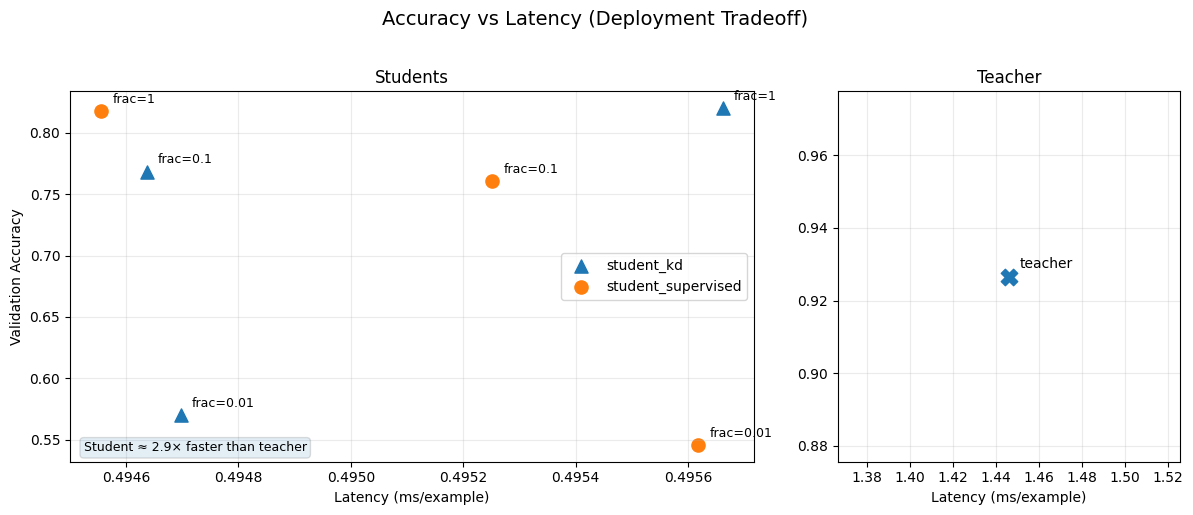

In [ ]:
import matplotlib.pyplot as plt

key_cols = ["mode","train_fraction","alpha","temperature","student_layers","student_hidden"]
plot_df = (
    results_df.copy()
      .sort_values("val_acc", ascending=False)
      .drop_duplicates(subset=key_cols, keep="first")
      .copy()
)

plot_df["ms_per_example"] = plot_df["sec_per_example"] * 1000

# teacher row
teacher = plot_df[plot_df["mode"] == "teacher"].iloc[0]
plot_df["speedup_x"] = teacher["sec_per_example"] / plot_df["sec_per_example"]

markers = {"teacher":"X", "student_supervised":"o", "student_kd":"^"}

students = plot_df[plot_df["mode"] != "teacher"].copy()
t = plot_df[plot_df["mode"] == "teacher"].copy()

# =========================
# Figure 1: Accuracy vs Latency
# =========================
fig, axes = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={"width_ratios":[2,1]})

# Left: Students
ax = axes[0]
for mode, g in students.groupby("mode"):
    ax.scatter(
        g["ms_per_example"], g["val_acc"],
        marker=markers.get(mode, "o"),
        s=90,
        label=mode
    )

for _, r in students.iterrows():
    ax.annotate(
        f'frac={r["train_fraction"]:g}',
        (r["ms_per_example"], r["val_acc"]),
        textcoords="offset points", xytext=(8,6), fontsize=9
    )

ax.text(
    0.02, 0.02,
    f"Student ≈ {students['speedup_x'].mean():.1f}× faster than teacher",
    transform=ax.transAxes,
    fontsize=9,
    va="bottom",
    bbox=dict(boxstyle="round", alpha=0.12)
)

ax.set_xlabel("Latency (ms/example)")
ax.set_ylabel("Validation Accuracy")
ax.set_title("Students")
ax.grid(True, alpha=0.25)
ax.legend()

ax = axes[1]
ax.scatter(t["ms_per_example"], t["val_acc"], marker="X", s=140, label="teacher")
ax.annotate(
    "teacher",
    (teacher["ms_per_example"], teacher["val_acc"]),
    textcoords="offset points", xytext=(8,6), fontsize=10
)
ax.set_xlabel("Latency (ms/example)")
ax.set_title("Teacher")
ax.grid(True, alpha=0.25)

fig.suptitle("Accuracy vs Latency (Deployment Tradeoff)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


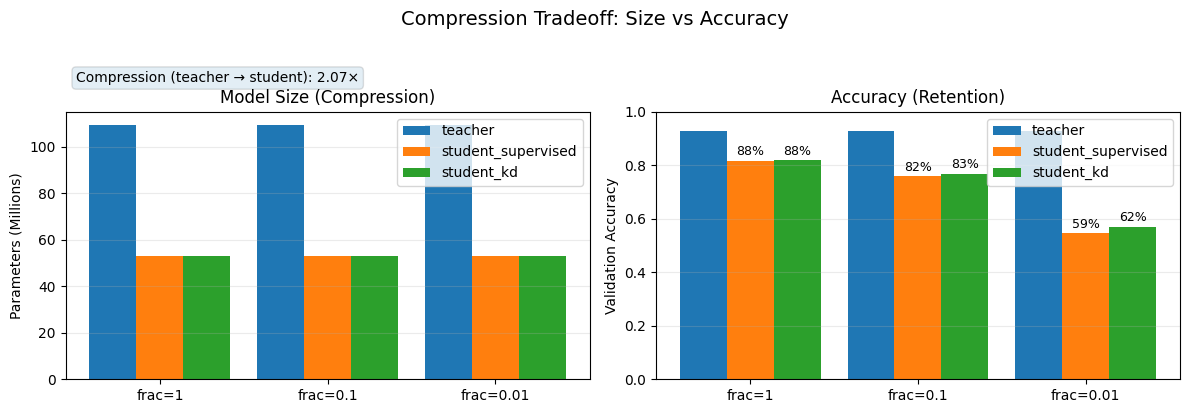

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

key_cols = ["mode","train_fraction","alpha","temperature","student_layers","student_hidden"]
df = (
    results_df.copy()
      .sort_values("val_acc", ascending=False)
      .drop_duplicates(subset=key_cols, keep="first")
      .copy()
)

teacher = df[df["mode"] == "teacher"].iloc[0]

# Compare teacher vs best supervised student vs best KD student for each fraction
fractions = [1.0, 0.1, 0.01]

rows = []
for frac in fractions:
    sup = df[(df["mode"] == "student_supervised") & (df["train_fraction"] == frac)]
    kd  = df[(df["mode"] == "student_kd") & (df["train_fraction"] == frac)]

    if len(sup) == 0 or len(kd) == 0:
        continue

    sup = sup.iloc[0]
    kd  = kd.iloc[0]

    rows.append({
        "train_fraction": frac,
        "teacher_params": teacher["params_millions"],
        "sup_params": sup["params_millions"],
        "kd_params": kd["params_millions"],
        "teacher_acc": teacher["val_acc"],
        "sup_acc": sup["val_acc"],
        "kd_acc": kd["val_acc"],
    })

xlabels = [f"frac={r['train_fraction']:g}" for r in rows]
x = np.arange(len(rows))
w = 0.28

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# -------------------------
# Panel A: Params (M)
# -------------------------
ax = axes[0]
teacher_params = [r["teacher_params"] for r in rows]
sup_params     = [r["sup_params"] for r in rows]
kd_params      = [r["kd_params"] for r in rows]

ax.bar(x - w, teacher_params, width=w, label="teacher")
ax.bar(x,     sup_params,     width=w, label="student_supervised")
ax.bar(x + w, kd_params,      width=w, label="student_kd")

ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ax.set_ylabel("Parameters (Millions)")
ax.set_title("Model Size (Compression)")
ax.grid(True, axis="y", alpha=0.25)
ax.legend()

comp = teacher["params_millions"] / sup_params[0]
ax.text(
    0.02, 1.1,
    f"Compression (teacher → student): {comp:.2f}×",
    transform=ax.transAxes,
    fontsize=10,
    va="bottom",
    bbox=dict(boxstyle="round", alpha=0.12)
)

# -------------------------
# Panel B: Accuracy + Retention %
# -------------------------
ax = axes[1]
teacher_acc = [r["teacher_acc"] for r in rows]
sup_acc     = [r["sup_acc"] for r in rows]
kd_acc      = [r["kd_acc"] for r in rows]

ax.bar(x - w, teacher_acc, width=w, label="teacher")
ax.bar(x,     sup_acc,     width=w, label="student_supervised")
ax.bar(x + w, kd_acc,      width=w, label="student_kd")

for i, (ta, sa, ka) in enumerate(zip(teacher_acc, sup_acc, kd_acc)):
    ax.text(i,     sa + 0.02, f"{(sa/ta)*100:.0f}%", ha="center", fontsize=9)
    ax.text(i + w, ka + 0.02, f"{(ka/ta)*100:.0f}%", ha="center", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ax.set_ylabel("Validation Accuracy")
ax.set_title("Accuracy (Retention)")
ax.set_ylim(0.0, 1.0)
ax.grid(True, axis="y", alpha=0.25)
ax.legend()

fig.suptitle("Compression Tradeoff: Size vs Accuracy", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

key_cols = ["mode","train_fraction","alpha","temperature","student_layers","student_hidden"]
df = (
    results_df.copy()
      .sort_values("val_acc", ascending=False)
      .drop_duplicates(subset=key_cols, keep="first")
      .copy()
)

# --- teacher reference ---
teacher = df[df["mode"] == "teacher"].iloc[0]

df["ms_per_example"] = df["sec_per_example"] * 1000
df["compression_x"] = teacher["params_millions"] / df["params_millions"]
df["speedup_x"] = teacher["sec_per_example"] / df["sec_per_example"]

# “preserves accuracy” as retention (e.g. 0.88 = retains 88% of teacher acc)
df["acc_retention"] = df["val_acc"] / teacher["val_acc"]

# Accuracy drop in points (e.g. -0.11 means -11 points)
df["acc_drop"] = df["val_acc"] - teacher["val_acc"]

# Higher is better: reward accuracy, reward speed, reward compression
df["efficiency_score"] = df["val_acc"] * np.log(df["compression_x"]) * np.log(df["speedup_x"])

view_cols = [
    "mode","train_fraction","alpha","temperature",
    "val_acc","acc_retention","acc_drop",
    "params_millions","ms_per_example",
    "compression_x","speedup_x",
    "efficiency_score",
    "student_layers","student_hidden"
]

summary = df[view_cols].sort_values("efficiency_score", ascending=False)

best_row = summary.iloc[0]
print(
    f'BEST (by efficiency_score): {best_row["mode"]} (frac={best_row["train_fraction"]}) '
    f'→ {best_row["compression_x"]:.2f}× smaller, {best_row["speedup_x"]:.2f}× faster, '
    f'{best_row["acc_retention"]*100:.1f}% accuracy retained.'
)

summary


BEST (by efficiency_score): student_kd (frac=1.0) → 2.07× smaller, 2.92× faster, 88.5% accuracy retained.


,mode,train_fraction,alpha,temperature,val_acc,acc_retention,acc_drop,params_millions,ms_per_example,compression_x,speedup_x,efficiency_score,student_layers,student_hidden
4,student_kd,1.00,0.7,2.0,0.819954,0.884901,-0.106651,52.780802,0.495662,2.074311,2.917524,0.640580,4.0,768.0
1,student_supervised,1.00,NaN,NaN,0.817661,0.882426,-0.108945,52.780802,0.494556,2.074311,2.924051,0.640122,4.0,768.0
5,student_kd,0.10,0.7,2.0,0.768349,0.829208,-0.158257,52.780802,0.494637,2.074311,2.923568,0.601424,4.0,768.0
2,student_supervised,0.10,NaN,NaN,0.760321,0.820545,-0.166284,52.780802,0.495251,2.074311,2.919943,0.594453,4.0,768.0
6,student_kd,0.01,0.7,2.0,0.569954,0.615099,-0.356651,52.780802,0.494698,2.074311,2.923211,0.446080,4.0,768.0
3,student_supervised,0.01,NaN,NaN,0.545872,0.589109,-0.380734,52.780802,0.495618,2.074311,2.917783,0.426492,4.0,768.0
0,teacher,1.00,NaN,NaN,0.926606,1.000000,0.000000,109.483778,1.446106,1.000000,1.000000,0.000000,NaN,NaN
